In [1]:
import numpy as np
import pickle, glob
from astropy.table import Table

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [26]:
def read_best_models(country, experience, weighted=False):
    best_models = []
    for fpkl in glob.glob('/Users/chahah/data/xgb_tutorial/models/%s.experience_%s%s/*.pkl' % 
              (country.lower().replace(' ', ''), experience, ['', '.weighted'][weighted])): 
        with open(fpkl, 'rb') as f:
            model = pickle.load(f)
        best_models.append(model)
    return best_models

In [5]:
def read_test_data(country, experience): 
    survey = Table.read('ejflooddata_combined.hdf5')
    city0 = survey[(survey['country'] == country) & (survey['res_length'] > 3.) & (survey['gender'] < 3.)]
    # properites of the population
    col_pop = ['self_vul', 'discrimination', 'education.recoded', 'income_USD', 'age', 'gender', 'queer', 'disability', 'language']

    X = np.array([city0[col] for col in col_pop]).T
    Y = np.array(city0['experience_%s' % experience]) # exposure to rain 

    # weights for data
    W = np.zeros(len(Y))
    for _y in np.unique(Y): 
        is_y = (Y.flatten() == _y)
        W[is_y] = 1/np.sum(is_y)
    W *= len(W)/np.sum(W)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, 
                                                                         test_size=0.2, random_state=42)
    return X_test, y_test, w_test

In [70]:
def Score(model, X_test, Y_test, W_test): 
    Y_pred = model.predict(X_test)
    #return np.sum(W_test * (Y_pred != Y_test).astype(float))/np.sum(W_test)
    return np.sum(W_test * (Y_pred - Y_test)**2)/np.sum(W_test)

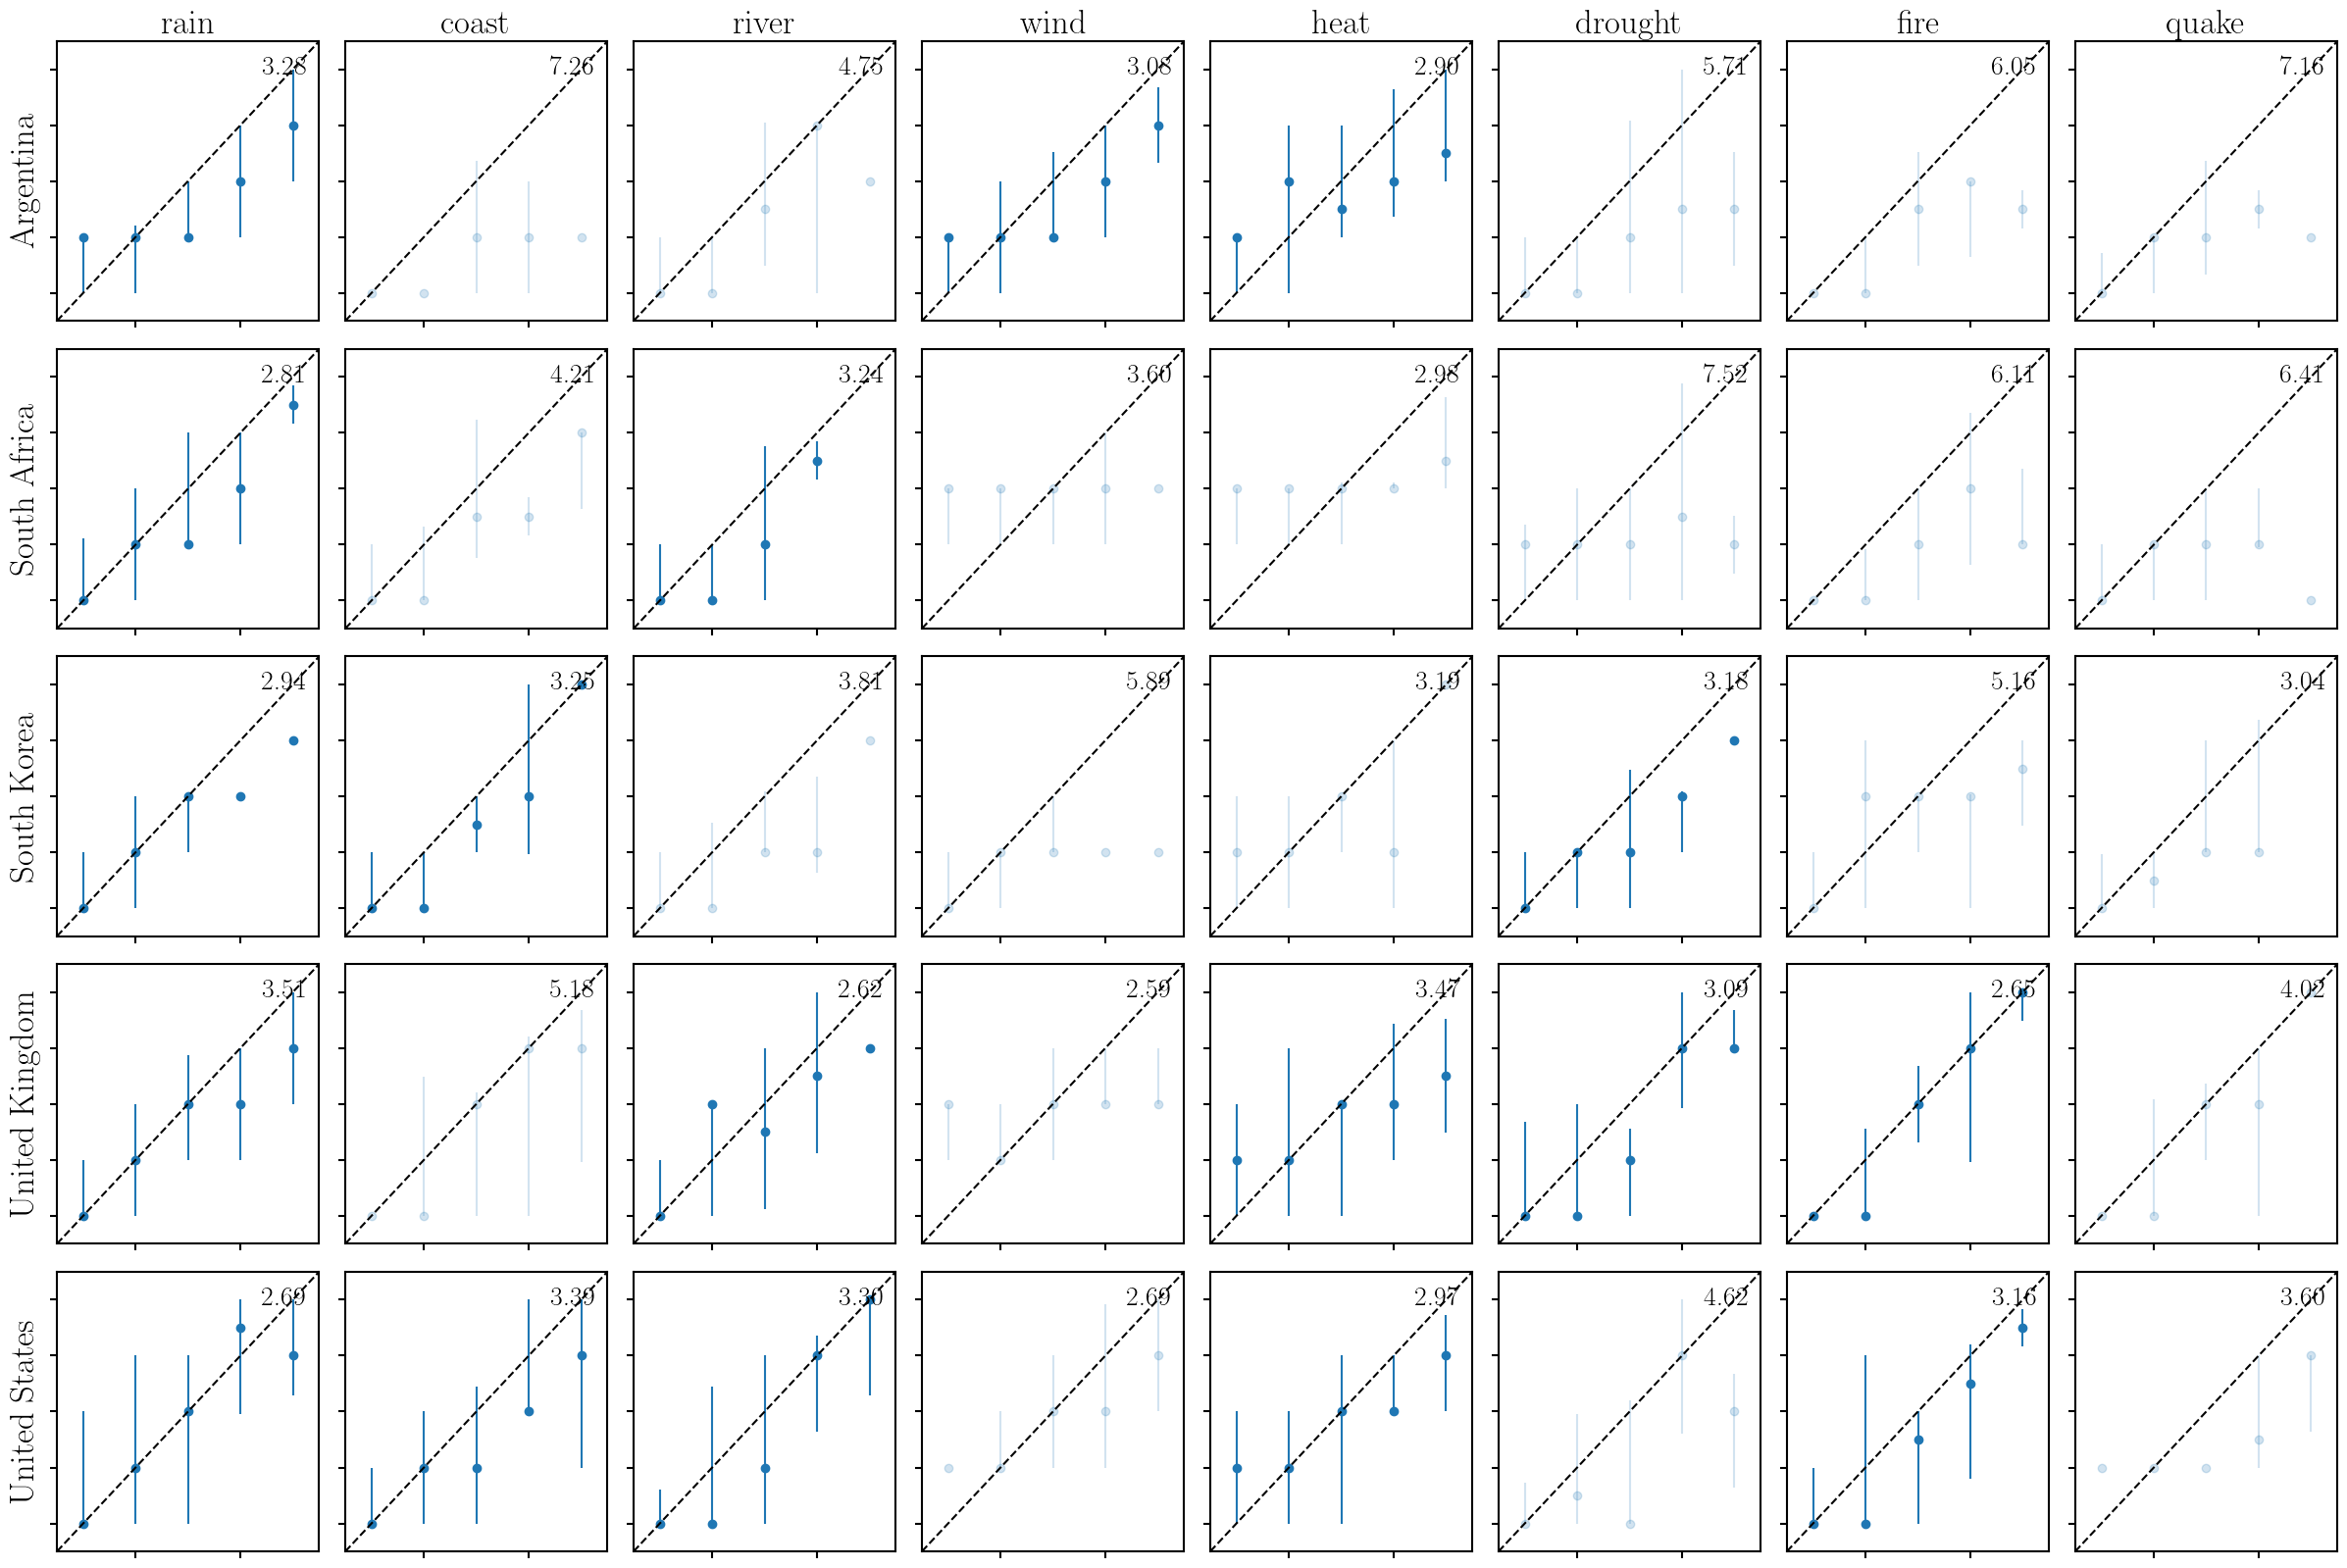

In [78]:
fig = plt.figure(figsize=(30,20))

feature_names = ['vulnerability', 'discrimination', 'education', 'income', 'age', 'gender', 'queer', 'disability', 'language']#, 'relocation']

for i, exposure in enumerate(['rain', 'coast', 'river', 'wind', 'heat', 'drought', 'fire', 'quake']): 
    for j, country in enumerate(['Argentina', 'South Africa', 'South Korea', 'United Kingdom', 'United States']): 
        sub = fig.add_subplot(5, 8, 8*j+i+1)
        
        X_test, Y_test, W_test = read_test_data(country, exposure)

        # models trained without weights
        best_models0 = read_best_models(country, exposure, weighted=False) 
        scores0 = [Score(model, X_test, Y_test, W_test) for model in best_models0]        
        test_score0 = np.min(scores0) 
        ibest0 = np.argmin(scores0)
        
        # models trained with weights
        best_models1 = read_best_models(country, exposure, weighted=True) 
        scores1 = [Score(model, X_test, Y_test, W_test) for model in best_models1]        
        test_score1 = np.min(scores1) 
        ibest1 = np.argmin(scores1)
        
        # select better models
        if test_score0 < test_score1: 
            best_models = best_models0 
            ibest = ibest0
        else: 
            best_models = best_models1
            ibest = ibest1
        
        reliable = True
        if j == 0: reliable = [True, False, False, True, True, False, False, False][i]
        if j == 1: reliable = [True, False, True, False, False, False, False, False][i]
        if j == 2: reliable = [True, True, False, False, False, True, False, False][i]
        if j == 3: reliable = [True, False, True, False, True, True, True, False][i]            
        if j == 4: reliable = [True, True, True, False, True, False, True, False][i]            
        
        y_preds = []
        for model in best_models: 
            y_pred = model.predict(X_test) + 1
            y_preds.append(y_pred)
        y_preds = np.array(y_preds)
                
        for u in np.arange(1,6):
            is_u = (Y_test == u).flatten()
            if np.sum(is_u) > 0: 
                q0, q1, q2 = np.quantile(y_preds[ibest,is_u], [0.16, 0.5, 0.84])
                sub.errorbar([u], [q1], [[q1-q0], [q2-q1]], c='C0', alpha=[0.2, 1.][reliable])
                sub.scatter([u], [q1], c='C0', alpha=[0.2, 1.][reliable])
        
        sub.plot([0.5, 5.5], [0.5, 5.5], c='k', ls='--')
        sub.set_xlim(0.5, 5.5)
        sub.set_ylim(0.5, 5.5)                
        sub.text(0.95, 0.95, '%.2f' % np.min([test_score0, test_score1]), ha='right', va='top', transform=sub.transAxes, fontsize=20)
        sub.set_yticklabels([])
        #sub.set_xlim(-0.5, len(model.feature_names)-0.5)
        sub.set_xticklabels([])
        if j == 0: sub.set_title(exposure.replace('_', ' '), fontsize=25)
        if i == 0: sub.set_ylabel(country, fontsize=25)

fig.subplots_adjust(hspace=0.1, wspace=0.1)

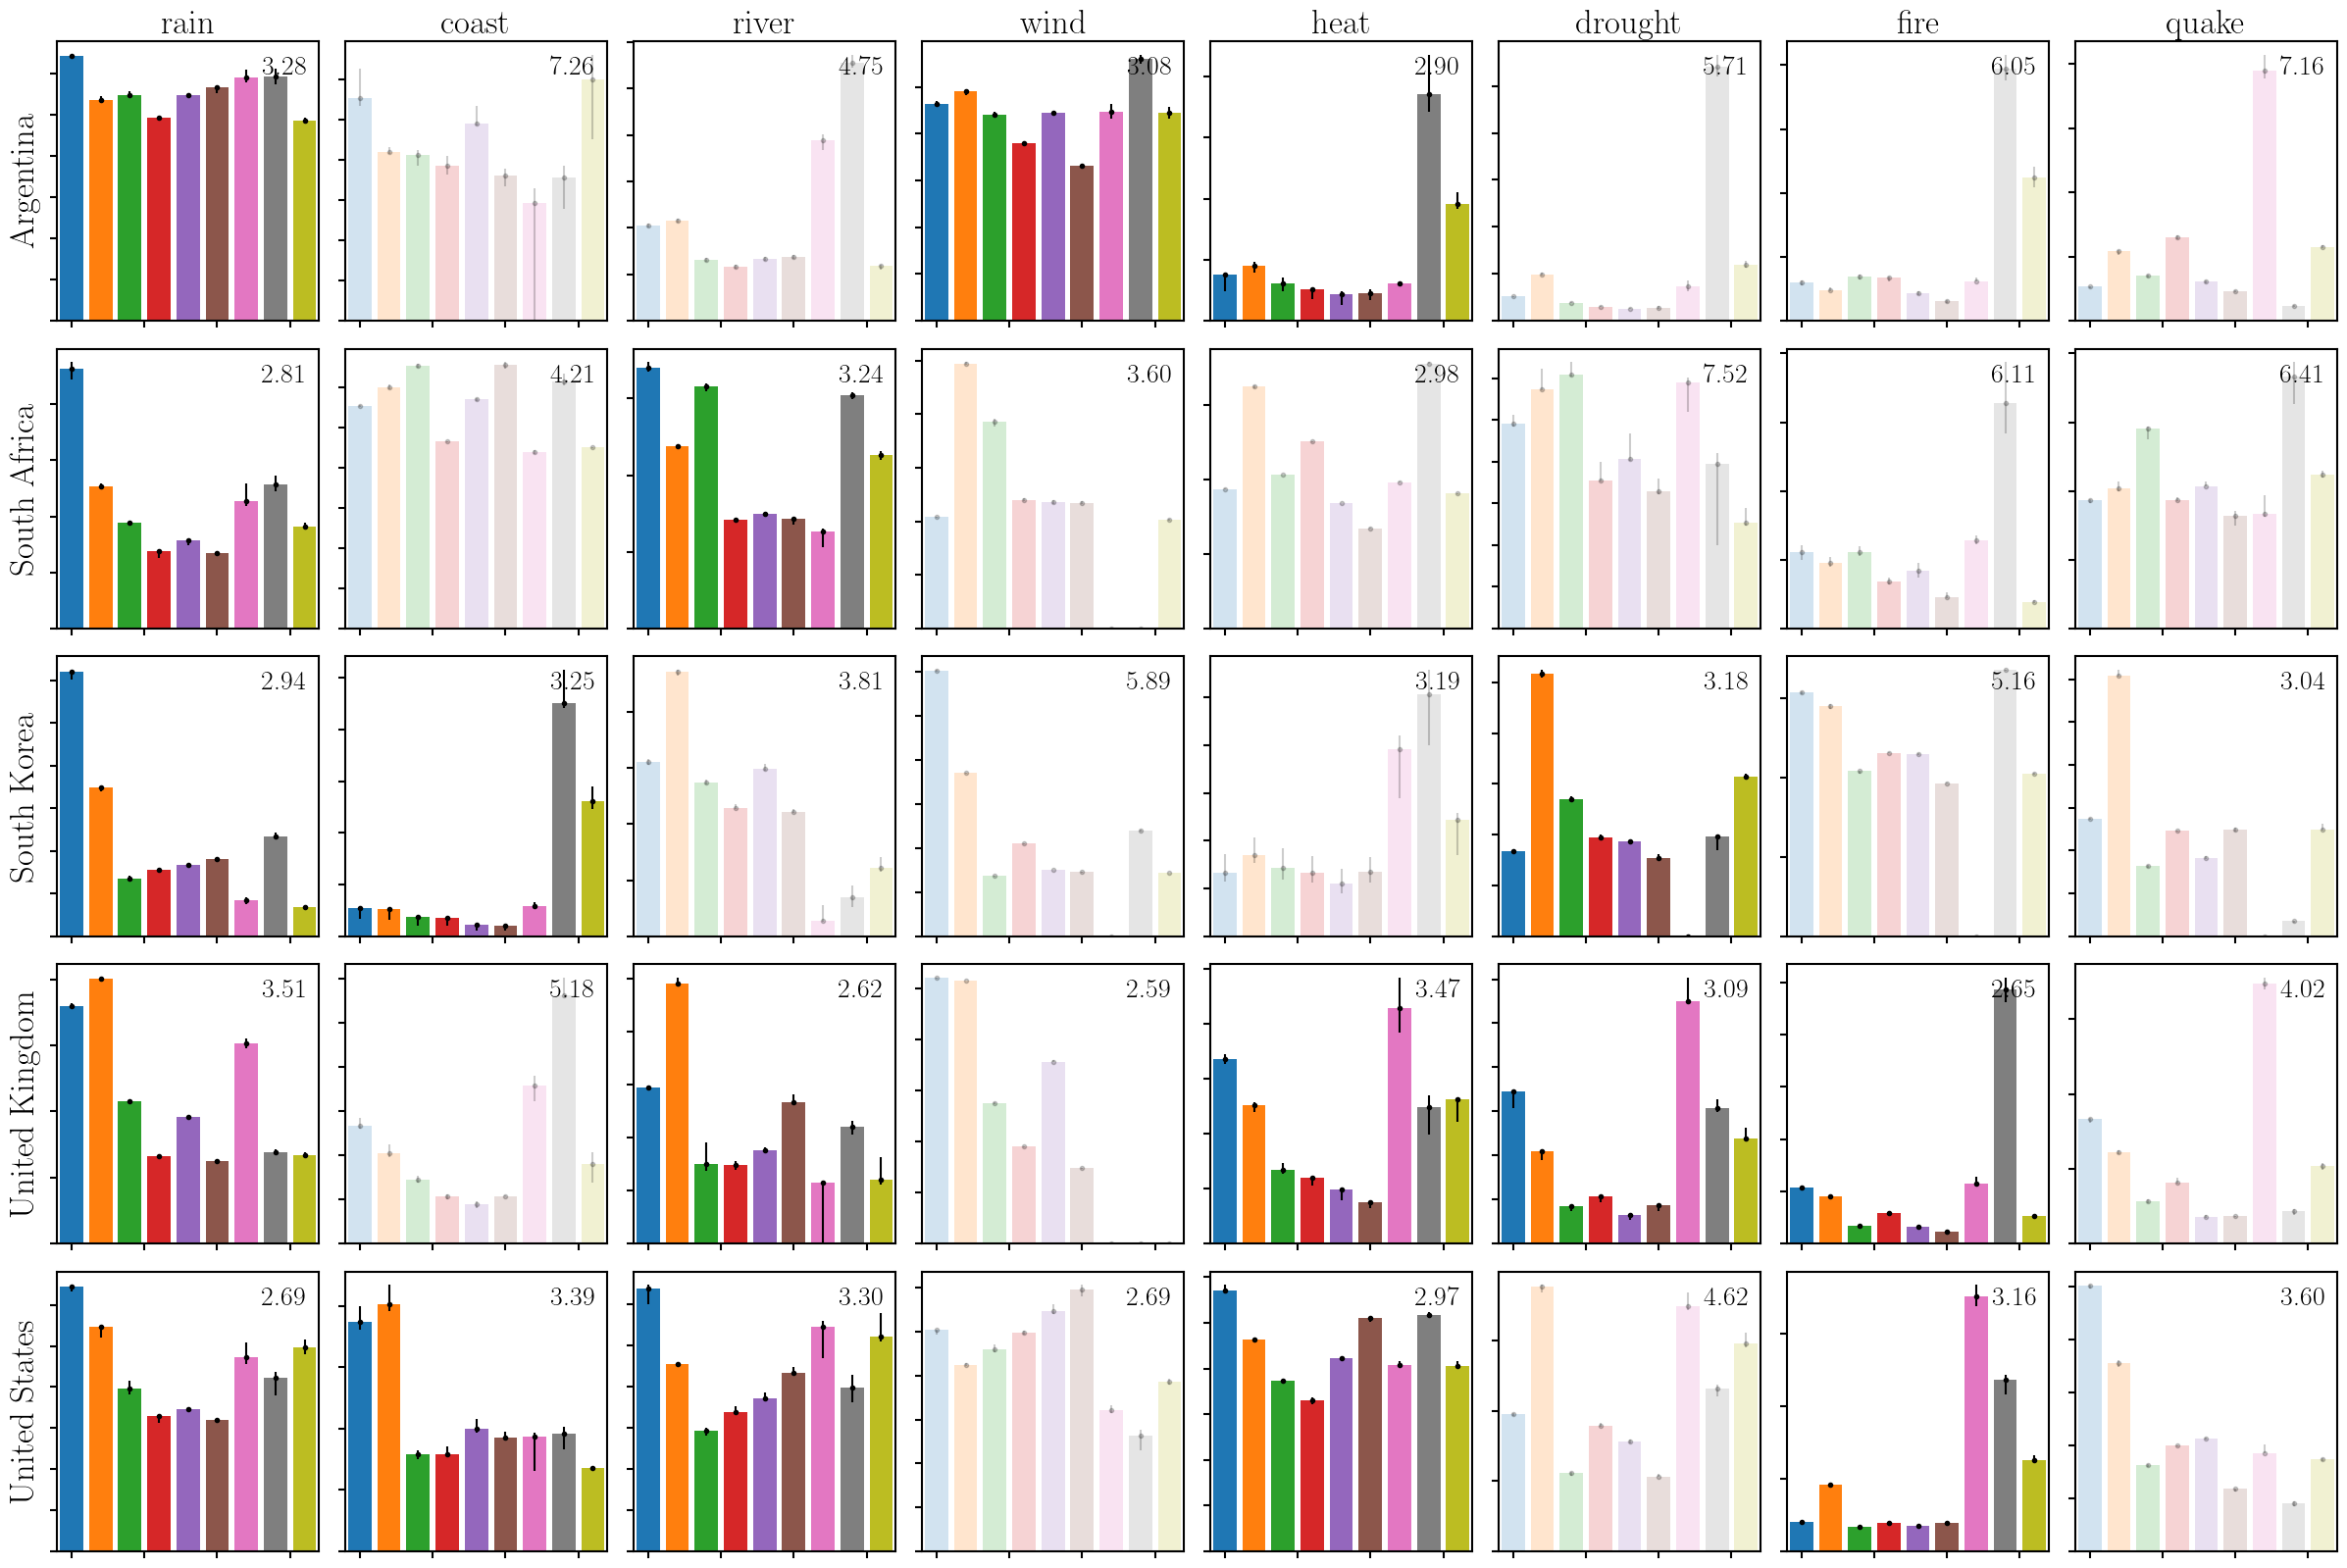

In [80]:
fig = plt.figure(figsize=(30,20))

feature_names = ['vulnerability', 'discrimination', 'education', 'income', 'age', 'gender', 'queer', 'disability', 'language']#, 'relocation']

for i, exposure in enumerate(['rain', 'coast', 'river', 'wind', 'heat', 'drought', 'fire', 'quake']): 
    for j, country in enumerate(['Argentina', 'South Africa', 'South Korea', 'United Kingdom', 'United States']): 
        sub = fig.add_subplot(5, 8, 8*j+i+1)
        
        X_test, Y_test, W_test = read_test_data(country, exposure)

        # models trained without weights
        best_models0 = read_best_models(country, exposure, weighted=False) 
        scores0 = [Score(model, X_test, Y_test, W_test) for model in best_models0]        
        test_score0 = np.min(scores0) 
        ibest0 = np.argmin(scores0)
        
        # models trained with weights
        best_models1 = read_best_models(country, exposure, weighted=True) 
        scores1 = [Score(model, X_test, Y_test, W_test) for model in best_models1]        
        test_score1 = np.min(scores1) 
        ibest1 = np.argmin(scores1)
        
        # select better models
        if test_score0 < test_score1: 
            best_models = best_models0 
            ibest = ibest0
        else: 
            best_models = best_models1
            ibest = ibest1
        
        reliable = True
        if j == 0: reliable = [True, False, False, True, True, False, False, False][i]
        if j == 1: reliable = [True, False, True, False, False, False, False, False][i]
        if j == 2: reliable = [True, True, False, False, False, True, False, False][i]
        if j == 3: reliable = [True, False, True, False, True, True, True, False][i]            
        if j == 4: reliable = [True, True, True, False, True, False, True, False][i]          

        feature_importances = []
        for best_model in best_models: 
            feature_importances.append(best_model.feature_importances_)
        feature_importances = np.array(feature_importances)    

        for ii in range(feature_importances.shape[1]): 
            q0, q1, q2 = np.quantile(feature_importances[:,ii], (0.16, 0.5, 0.84))
            sub.errorbar([ii], [q1], [[q2-q1], [q1-q0]], fmt='.k', zorder=20, alpha=[0.2, 1.][reliable])
            sub.bar([ii], [q1], color='C%i' % ii, alpha=[0.2, 1.][reliable])   
            
        sub.set_xlim(-0.5, feature_importances.shape[1]-0.5)
        sub.set_ylim(0., None)                
        sub.text(0.95, 0.95, '%.2f' % np.min([test_score0, test_score1]), ha='right', va='top', transform=sub.transAxes, fontsize=20)
        sub.set_yticklabels([])
        #sub.set_xlim(-0.5, len(model.feature_names)-0.5)
        sub.set_xticklabels([])
        if j == 0: sub.set_title(exposure.replace('_', ' '), fontsize=25)
        if i == 0: sub.set_ylabel(country, fontsize=25)

fig.subplots_adjust(hspace=0.1, wspace=0.1)

474
44


Text(0, 0.5, 'Exposure')

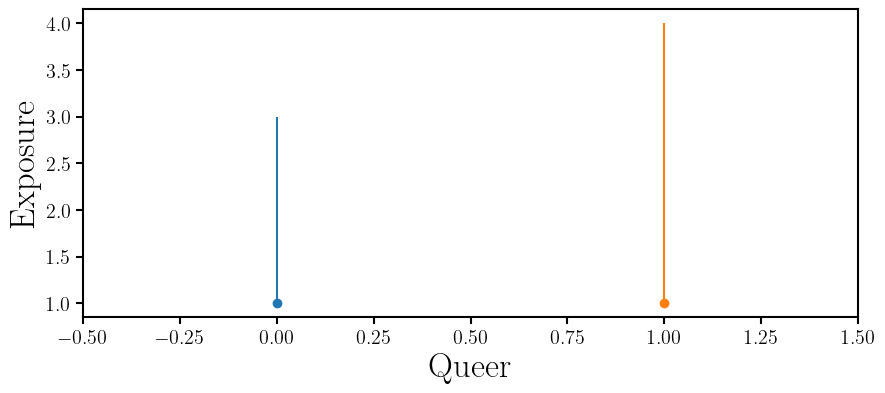

In [101]:
survey = Table.read('ejflooddata_combined.hdf5')
country = 'United States'
expsoure = 'fire'
cut = (survey['country'] == country) & (survey['res_length'] > 3.) & (survey['gender'] < 3.)

_X = survey['queer'][cut]
_Y = survey['experience_%s' % exposure][cut]

fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(111)
for u_x in np.unique(_X): 
    is_x = (_X == u_x)
    print(np.sum(is_x))
    q0, q1, q2 = np.quantile(_Y[is_x], [0.16, 0.5, 0.84])
    
    sub.errorbar([u_x], [q1], [[q1-q0], [q2-q1]])
    sub.scatter([u_x], [q1])
sub.set_xlabel('Queer', fontsize=25)
sub.set_xlim(_X.min()-0.5, _X.max()+0.5)

sub.set_ylabel('Exposure', fontsize=25)

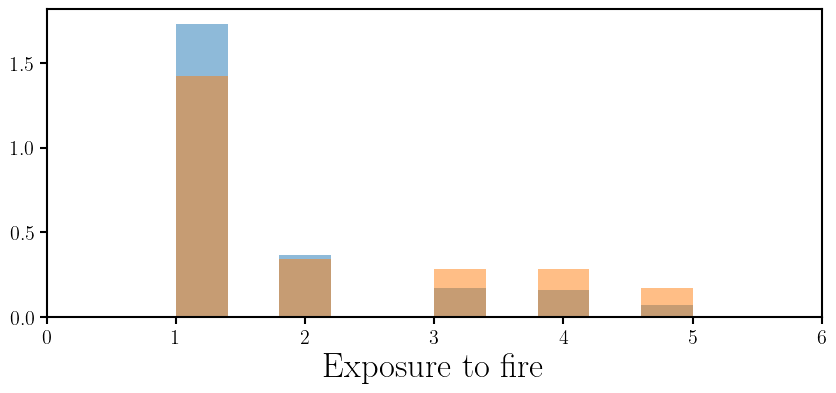

In [102]:
country = 'United States'

for exposure in ['fire']: 
    cut = (survey['country'] == country) & (survey['res_length'] > 3.) & (survey['gender'] < 3.)

    _X = survey['queer'][cut]
    _Y = survey['experience_%s' % exposure][cut]

    fig = plt.figure(figsize=(10,4))
    sub = fig.add_subplot(111)
    sub.hist(_Y[_X == 0], alpha=0.5, density=True)
    sub.hist(_Y[_X == 1], alpha=0.5, density=True)
    sub.set_xlabel('Queer', fontsize=25)
    sub.set_xlim(0., 6)#sub.set_xlim(_X.min()-0.5, _X.max()+0.5)

    sub.set_xlabel('Exposure to %s' % exposure, fontsize=25)